# Емельянова Елизавета Всеволодовна БВТ2201


# Лабаораторная работа №1: Аудио EDA и характеристики сигнала

**Цель:** научиться загружать аудиодатасеты, читать и интерпретировать метаданные, вычислять базовые характеристики аудиосигнала и строить визуализации (waveform, спектр, Mel/Log‑Mel).  
**Формат:** заполнить `TODO`‑ячейки. Ячейки с `raise NotImplementedError` необходимо заменить вашим кодом.

**Требования по оформлению графиков:** используйте `matplotlib` (без seaborn), один график на фигуру, не задавайте кастомные цвета.

**Зависимости:** `datasets[audio]`, `librosa`, `numpy`, `matplotlib`, `soundfile`, `tqdm`.


In [ ]:
!pip install -q datasets[audio] librosa soundfile matplotlib numpy tqdm

import os, json, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset, Audio
import librosa, librosa.display
import soundfile as sf

from IPython.display import Audio, display

import warnings; warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED); np.random.seed(SEED)



## Задание 1. Выбор и загрузка датасета(ов)

**Варианты:**
- Речь (например, `PolyAI/minds14`, любая локаль).
- Звуки окружения (любой датасет на HF Hub или локальная папка WAV/FLAC).

**Что сделать:**
1. Указать идентификатор/путь датасета.
2. Загрузить сплит (например, `train` или подвыборку).
3. Показать структуру фич и пример записи.


In [ ]:
# TODO-1.1: укажите идентификатор (или оставьте None для локальной загрузки)
DATASET_ID = "Vikhrmodels/ToneSpeak"
DATASET_SPLIT = "train"

# TODO-1.2: загрузка датасета через 🤗 Datasets
try:
    ds = load_dataset(DATASET_ID, split=DATASET_SPLIT)
except Exception as e:
    print("Не удалось загрузить датасет через load_dataset:", e)
    ds = None

In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00


In [ ]:
def preview(ds, n=1):
    if ds is None:
        print("Dataset is None")
        return
    print(ds)
    print("Пример: ", ds[n])

    audio_data = ds[n]["audio"]
    array, sr = audio_data["array"], audio_data["sampling_rate"]
    print(f"sampling_rate: {sr}")
    display(Audio(data=array, rate=sr))

preview(ds, n=5)


Dataset({
    features: ['audio', 'text', 'text_description', 'voice_name'],
    num_rows: 6298
})
Пример:  {'audio': <datasets.features._torchcodec.AudioDecoder object at 0x7b74d7bafad0>, 'text': 'Весенний ветер мягко колышет ветви деревьев, наполняя воздух свежестью и лёгкой прохладой, создавая умиротворённое настроение для прогулки по парку.', 'text_description': 'Accent: Стандартное московское произношение без региональных особенностей.\nTone: Нежный и спокойный, создающий ощущение уюта.\nEmotion: Лёгкая радость и умиротворение, передающие весеннее настроение.\nPauses: Естественные паузы между смысловыми частями для удобства восприятия.\nPhrasing: Чёткое выделение ключевых слов для лучшего понимания смысла.', 'voice_name': 'alloy'}
sampling_rate: 24000



## Задание 2. Базовые характеристики аудиосигнала

**Что посчитать для N примеров:**
- Частота дискретизации (SR), длительность (с), количество каналов.
- Пиковый уровень (max |x|), RMS‑уровень, оценка динамического диапазона (приближенно).
- Коэффициент клиппинга (% сэмплов с |x|≈1.0 при float или на границе int).
- Zero‑Crossing Rate (ZCR), спектральный центроид и полосa (bandwidth).
- (Опционально) Оценка SNR при простой модели шума (на ваш выбор).

**Вывести:**
- Сводную таблицу (словари/списки), а также агрегаты: mean/median/p95.


In [ ]:
# TODO-2.1: реализуйте функции вычисления характеристик
def num_channels(arr: np.ndarray) -> int:
    """Возвращает количество каналов (1 для моно)."""
    if arr.ndim == 1: return 1
    elif arr.ndim == 2:
        return arr.shape[0] if arr.shape[0] < arr.shape[1] else arr.shape[1]
    else:
        print("Невозможно определить количество каналов из формы массива")

def peak_level(arr: np.ndarray) -> float:
    """Пиковый уровень max |x| для float в [-1, 1]."""
    return float(np.max(np.abs(arr)))

def rms_level(arr: np.ndarray) -> float:
    """RMS-уровень сигнала."""
    return float(np.sqrt(np.mean(arr**2)))

def clipping_ratio(arr: np.ndarray, thr: float = 0.999) -> float:
    """Доля сэмплов близких к клиппингу (|x| >= thr)."""
    return float(len([x for x in arr if abs(x) >= thr]) / len(arr))

def zero_crossing_rate(arr: np.ndarray) -> float:
    """Оценка ZCR (число пересечений нуля / длина)."""
    return float(np.sum(np.abs(np.diff(np.sign(arr))) > 0) / len(arr))

def spectral_stats(arr: np.ndarray, sr: int):
    """Спектральные признаки: центроид и полоса (bandwidth)."""
    return librosa.feature.spectral_centroid(y=arr, sr=sr) / librosa.feature.spectral_bandwidth(y=arr, sr=sr)

def duration_seconds(arr: np.ndarray, sr: int) -> float:
    return len(arr) / float(sr)


In [ ]:
def to_mono(arr: np.ndarray) -> np.ndarray:
  """Конвертация в моно."""
  if arr.ndim == 1:
    return arr
  elif arr.ndim == 2:
      if arr.shape[0] < arr.shape[1]:
          return np.mean(arr, axis=0)
      else:
          return np.mean(arr, axis=1)
  else:
        return np.mean(arr, axis=-1)

# TODO-2.2: пройдите по подвыборке датасета и соберите метрики
N = 200  # размер подвыборки для оценки
metrics = []

if ds is not None:
    idxs = np.random.choice(len(ds), size=min(N, len(ds)), replace=False)
    for i in tqdm(idxs, desc="Computing metrics"):
        ex = ds[int(i)]
        aud = ex["audio"]
        arr, sr = aud["array"], aud["sampling_rate"]
        if arr is None or sr is None:
            continue
        # Если многоканальный — приведите к моно для метрик или учитывайте каналы отдельно
        if (num_channels(arr) > 1): arr = to_mono(arr)

        m = {
            "sr": sr,
            "dur_s": duration_seconds(arr, sr),
            "channels": num_channels(arr),
            "peak": peak_level(arr),
            "rms": rms_level(arr),
            "clip_ratio": clipping_ratio(arr),
            "zcr": zero_crossing_rate(arr),
        }
        sc = spectral_stats(arr, sr)  # ожидается dict с ключами, например, 'centroid', 'bandwidth'
        if isinstance(sc, dict): m.update(sc)
        metrics.append(m)

metrics[:3]  # просмотр первых строк


Computing metrics: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


[{'sr': 24000,
  'dur_s': 8.808,
  'channels': 1,
  'peak': 0.5547124147415161,
  'rms': 0.0855933204293251,
  'clip_ratio': 0.0,
  'zcr': 0.08150734181047532},
 {'sr': 24000,
  'dur_s': 17.112,
  'channels': 1,
  'peak': 0.22147142887115479,
  'rms': 0.030532430857419968,
  'clip_ratio': 0.0,
  'zcr': 0.1487990883590463},
 {'sr': 24000,
  'dur_s': 16.32,
  'channels': 1,
  'peak': 0.312522292137146,
  'rms': 0.027709836140275,
  'clip_ratio': 0.0,
  'zcr': 0.13388480392156862}]

In [ ]:
# TODO-2.3: агрегируйте метрики и выведите сводку (mean/median/p95)
import numpy as np

def agg(values):
    if not values: return {"mean": None, "median": None, "p95": None}
    arr = np.array(values, dtype=float)
    return {"mean": float(np.mean(arr)), "median": float(np.median(arr)), "p95": float(np.percentile(arr, 95))}

def summarize(metrics):
    keys = [k for k in metrics[0].keys() if isinstance(metrics[0][k], (int, float))]
    summary = {}
    for k in keys:
        summary[k] = agg([m[k] for m in metrics if m.get(k) is not None])
    return summary

if metrics:
    summary = summarize(metrics)
    print(json.dumps(summary, indent=2, ensure_ascii=False))
else:
    print("Нет метрик для сводки — проверьте загрузку/вычисления.")


{
  "sr": {
    "mean": 24000.0,
    "median": 24000.0,
    "p95": 24000.0
  },
  "dur_s": {
    "mean": 14.91912,
    "median": 15.024000000000001,
    "p95": 19.5144
  },
  "channels": {
    "mean": 1.0,
    "median": 1.0,
    "p95": 1.0
  },
  "peak": {
    "mean": 0.5614283499866723,
    "median": 0.6457774937152863,
    "p95": 0.8279052913188933
  },
  "rms": {
    "mean": 0.06798230053856968,
    "median": 0.07696995139122009,
    "p95": 0.10235267616808415
  },
  "clip_ratio": {
    "mean": 0.0,
    "median": 0.0,
    "p95": 0.0
  },
  "zcr": {
    "mean": 0.12951356520799323,
    "median": 0.13121089642096923,
    "p95": 0.16361198915649788
  }
}



## Задание 3. Визуализация: waveform, спектр, Mel/Log‑Mel

**Что сделать:**
1. Построить waveform для нескольких примеров (ось x — время, y — амплитуда).
2. STFT‑спектрограмму в dB (логарифмическая шкала по амплитуде).
3. Mel‑спектрограмму и Log‑Mel при разных параметрах (`n_fft`, `hop_length`, `n_mels`, `fmax`, `htk/slaney`).
4. Сравнить как минимум 3 конфигурации и описать наблюдения в тексте.


In [ ]:
# TODO-3.1: вспомогательные функции визуализации
def plot_waveform(arr, sr, title="Waveform"):
    plt.figure()
    librosa.display.waveshow(arr, sr=sr)
    plt.title(title); plt.xlabel("Time"); plt.ylabel("Amplitude"); plt.show()

def plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram (dB)"):
    import numpy as np
    D = librosa.stft(arr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title); plt.colorbar(); plt.show()

def plot_mel_logmel(arr, sr, n_fft=2048, hop_length=512, n_mels=80, fmax=None, htk=False, title_prefix="Mel"):
    import numpy as np
    mel = librosa.feature.melspectrogram(y=arr, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax, htk=htk)
    logmel = librosa.power_to_db(mel, ref=np.max)
    plt.figure()
    librosa.display.specshow(logmel, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
    plt.title(f"{title_prefix}: log-Mel (n_mels={n_mels}, htk={htk})"); plt.colorbar(); plt.show()
    return mel, logmel


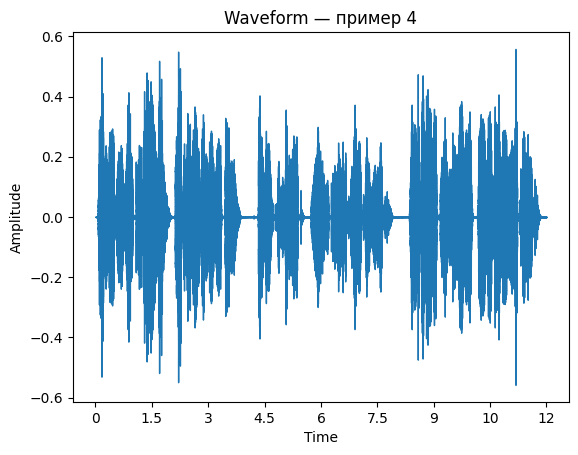

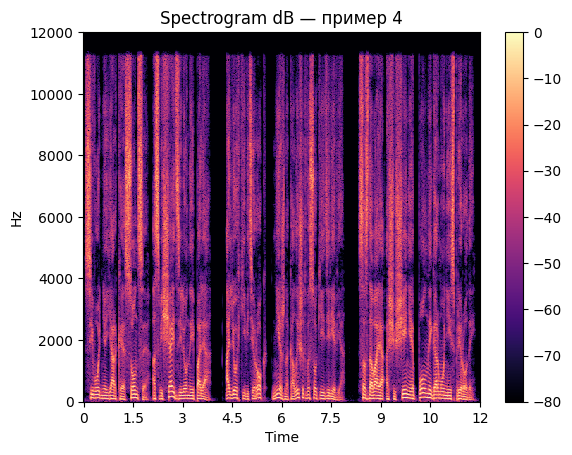

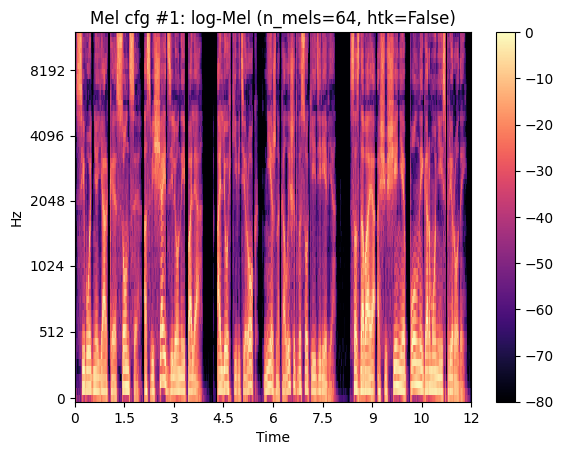

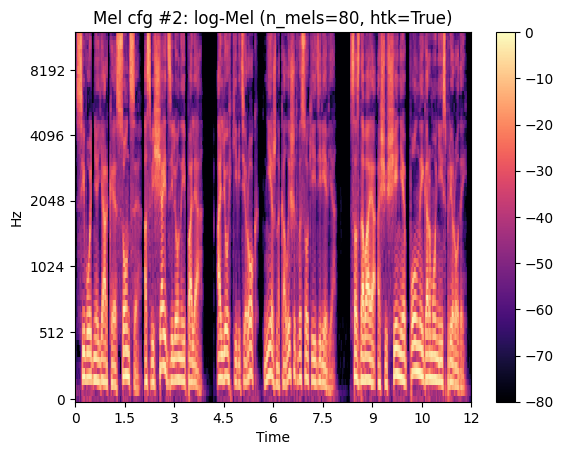

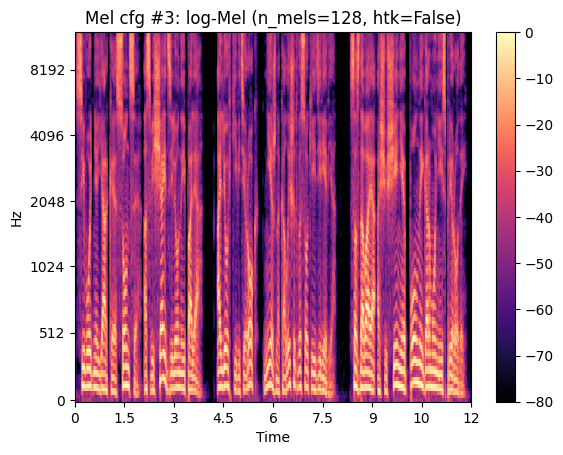

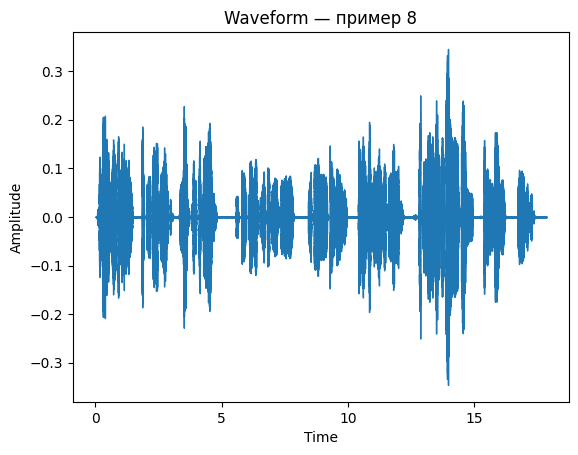

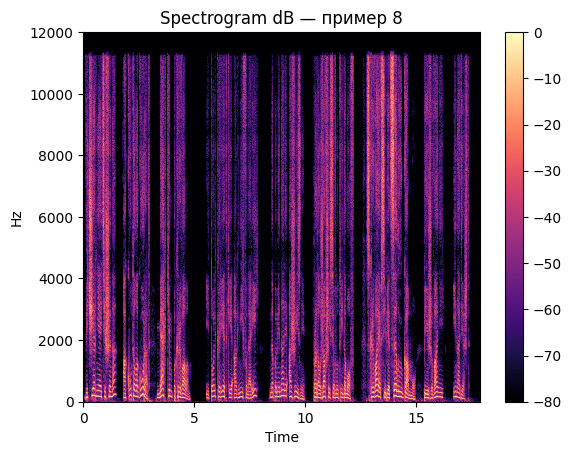

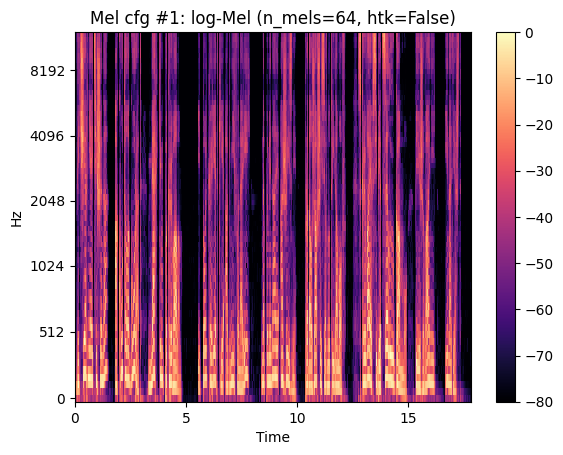

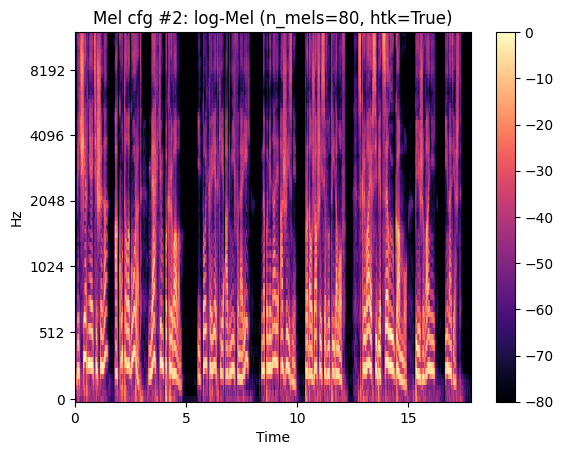

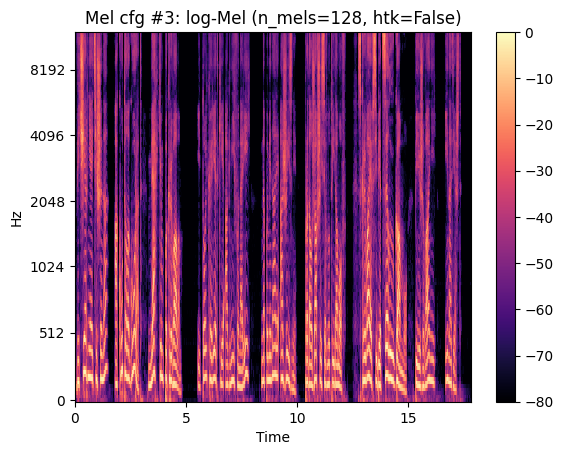

In [ ]:
# TODO-3.2: выберите 1-2 примера и постройте все типы визуализаций
if ds is not None and len(ds) > 0:
    for n in [4, 8]:  # номера примеров из датасета
        ex = ds[n]
        arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']
        plot_waveform(arr, sr, title=f"Waveform — пример {n}")
        plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title=f"Spectrogram dB — пример {n}")
        # Mel/Log‑Mel: сравнение конфигураций
        cfgs = [
            dict(n_fft=1024, hop_length=256, n_mels=64, fmax=8000, htk=False),
            dict(n_fft=2048, hop_length=512, n_mels=80, fmax=8000, htk=True),
            dict(n_fft=2048, hop_length=256, n_mels=128, fmax=8000, htk=False),
        ]
        for i, cfg in enumerate(cfgs):
            plot_mel_logmel(arr, sr, **cfg, title_prefix=f"Mel cfg #{i+1}")
else:
    print("Датасет пуст или не загружен.")


Выводы:
*   Чем больше значение n_fft, тем лучше мы можем различать частоты (получаем более узкие полосы частот), но хуже отслеживаем изменения во времени (получаем меньше кадров в секунду). В конфигурациях 2 и 3 (где n_fft=2048) спектрограммы более подробные по частоте, но менее плавные во времени.
*   При увеличении n_mels Мэл спектрограмма становится более гладкой и детализированной в распределении энергии по частотам. Это хорошо для задач распознавания, но может усложнить визуальный анализ.
*   HTK (True) и Slaney (False) имеют разные подходы к созданию мел-фильтров. Slaney больше соответствует тому, как наше ухо воспринимает звук, и дает более плавный и естественный спектр. HTK — это традиционный метод, который часто использовался в старых системах обработки звука.


## Задание 4. Передискретизация и сравнение (resampling)

**Что сделать:**
1. Передискретизировать сигнал до 16 kHz (если исходно другой SR) и сравнить waveform/спектры до/после.
2. Посчитать Nyquist‑частоту для обеих SR и обсудить, какие частоты потенциально теряются.
3. Оценить влияние `hop_length` при фиксированном `n_fft` на временное/частотное разрешение.


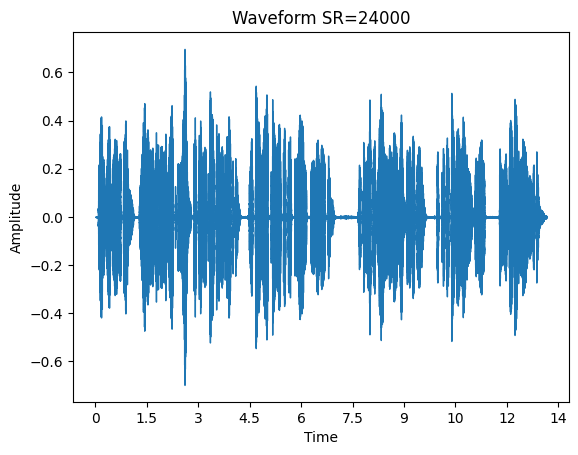

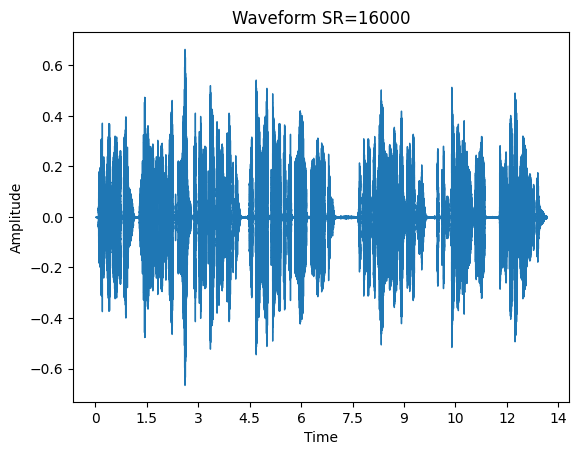

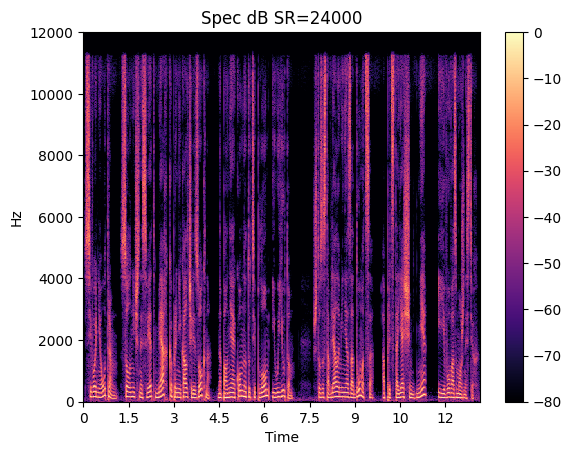

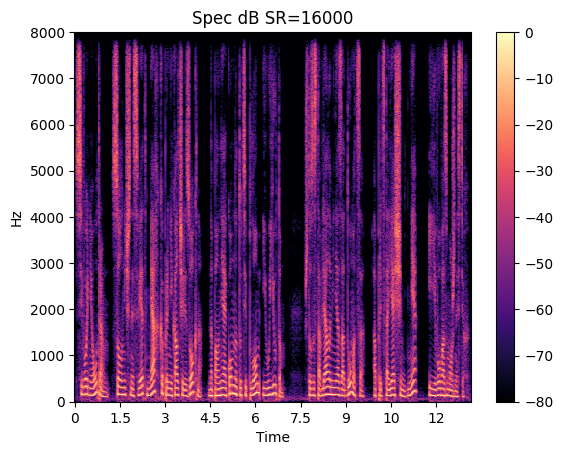

Nyquist исходный: 12000.0 Hz; после: 8000.0 Hz


In [ ]:
# TODO-4.1: ресемплинг и сравнение
TARGET_SR = 16_000

def resample(arr, sr, target_sr=TARGET_SR):
    if sr == target_sr:
        return arr, sr
    return librosa.resample(y=arr, orig_sr=sr, target_sr=target_sr), target_sr

def nyquist(sr):
    return sr / 2.0

if ds is not None and len(ds) > 0:
    ex = ds[0]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']
    arr2, sr2 = resample(arr, sr, TARGET_SR)
    # Визуальное сравнение
    plot_waveform(arr, sr, title=f"Waveform SR={sr}")
    plot_waveform(arr2, sr2, title=f"Waveform SR={sr2}")
    plot_spectrogram_db(arr, sr, title=f"Spec dB SR={sr}")
    plot_spectrogram_db(arr2, sr2, title=f"Spec dB SR={sr2}")
    print("Nyquist исходный:", nyquist(sr), "Hz; после:", nyquist(sr2), "Hz")
else:
    print("Датасет пуст или не загружен.")


Выводы:

При передискретизации:

- Если в оригинальном сигнале присутствовали частоты выше 8 kHz, они будут недоступны после передискретизации, что может привести к искажению звука.

Влияние hop_length при фиксированном n_fft на временное/частотное разрешение

*   Меньший hop_length (например, 256):
    Позволяет захватить более тонкие изменения во времени, что улучшает временное разрешение и позволяет получить больше кадров в спектрограмме. Однако увеличение количества кадров приводит к большей вычислительной нагрузке и увеличению размера данных.

*   Большее hop_length (например, 1024):
    Уменьшает количество получаемых кадров, что снижает временное разрешение. Это может привести к потере деталей, особенно если в сигнале происходят быстрые изменения, но уменьшает вычислительные затраты и размер выходных данных.



## Задание 5. Dataset‑level EDA

**Что сделать:**
1. Построить распределения длительностей, SR, пиковых уровней (гистограммы).
2. (Если есть метки классов) — подсчитать число примеров по классам.
3. Сформировать короткие выводы о качестве сырого датасета (наличие очень коротких/длинных записей, клиппинг и пр.).


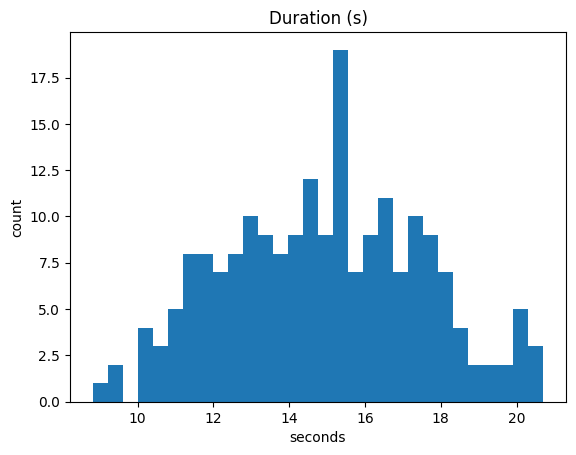

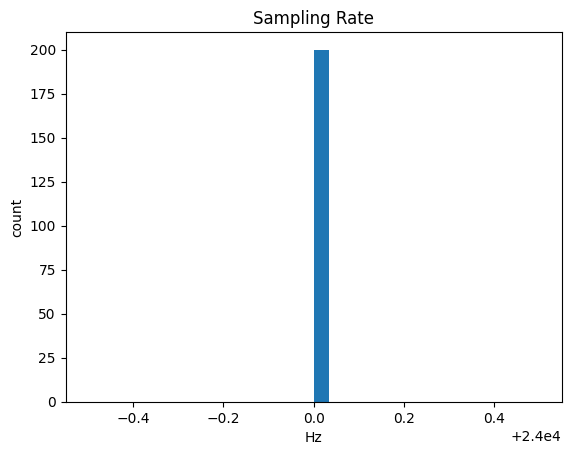

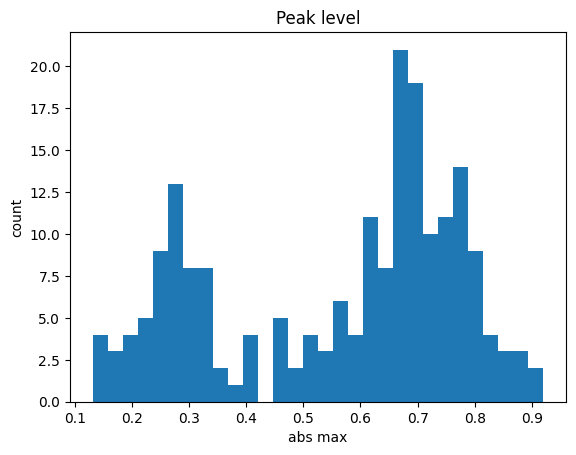

In [ ]:
# TODO-5.1: гистограммы и распределения
def hist(values, bins=30, title="Histogram", xlabel="value"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("count"); plt.show()

if metrics:
    hist([m['dur_s'] for m in metrics if m.get('dur_s') is not None], title="Duration (s)", xlabel="seconds")
    hist([m['sr'] for m in metrics if m.get('sr') is not None], title="Sampling Rate", xlabel="Hz")
    hist([m['peak'] for m in metrics if m.get('peak') is not None], title="Peak level", xlabel="abs max")


Выводы:
*   Диаграмма распределения длительностей выглядит как нормальное распределение, это указывает на то, что большинство аудиозаписей имеет среднюю длительность, а число очень коротких и очень длинных записей минимально. Записи единообразны и имеют хорошую структурированность, что, в свою очередь, упростит обучение модели и повысит её производительность.
*   Поскольку все аудиозаписи имеют одинаковую частоту дискретизации, это устраняет потенциальные проблемы, связанные с несовместимостью частоты при обработке данных.
*   Поскольку нет записей с пиковыми уровнями выше 1, это хороший индикатор того, что записи не подвергались клиппингу. Клиппинг возникает, когда амплитуда сигнала превышает максимально допустимый уровень, что может привести к искажению звука.